In [204]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Convolution2D, MaxPooling2D,LSTM
from keras.optimizers import Adam,RMSprop
from keras.utils import np_utils
from sklearn import metrics 

# import audio data and preprocessing, convert
1. extract data from audio file
2. standardlize
3. preprocessing data, delete low voice(no information) part, keep same length of each file

In [61]:
data_dir = 'data/train/'
audio_dir = [data_dir+i for i in os.listdir(data_dir)]

In [149]:
audio_data=[]
for i in range(0,len(audio_dir)):
    data, sampling_rate = librosa.load(audio_dir[i])
    audio_data.append(data[:60000])
data=np.array(audio_data)

Get a first view of spoken words: 0,1,2,3,4,7

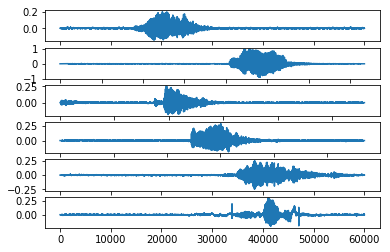

In [87]:
plt.subplot(6,1,1)
plt.plot(audio_data[0])
plt.subplot(6,1,2)
plt.plot(audio_data[1])
plt.subplot(6,1,3)
plt.plot(audio_data[2])
plt.subplot(6,1,4)
plt.plot(audio_data[3])
plt.subplot(6,1,5)
plt.plot(audio_data[4])
plt.subplot(6,1,6)
plt.plot(audio_data[5])
plt.show()

Try to standardlize data, into same length and delete none information part

In [152]:
# preprocessing data, by finding the cut_point (beginning of information data)
def begin_point(input_data):
    for i in range(0,60):
        sound= np.absolute(input_data[1000*i:1000*(i+5)])
        sound_mean=np.mean(sound)
        if sound_mean>0.01:
            return i*1000

In [171]:
def cut_data(input_data):
    cuted_data=np.zeros((len(input_data),20000),float)
    for i in range(0,len(input_data)):
        sound_data=input_data[i]
        begin = begin_point(sound_data)
        new_data= sound_data[begin:begin+20000]
        cuted_data[i]=new_data
    return cuted_data

cuteddd_data= cut_data(data)

new data look like this:

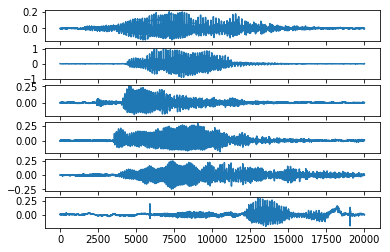

In [158]:
plt.subplot(6,1,1)
plt.plot(cuteddd_data[0])
plt.subplot(6,1,2)
plt.plot(cuteddd_data[1])
plt.subplot(6,1,3)
plt.plot(cuteddd_data[2])
plt.subplot(6,1,4)
plt.plot(cuteddd_data[3])
plt.subplot(6,1,5)
plt.plot(cuteddd_data[4])
plt.subplot(6,1,6)
plt.plot(cuteddd_data[5])
plt.show()

listen to it

In [159]:
ipd.Audio(cuteddd_data[5],rate=22050)

# feature selection
1. MFCC  --extracted features for MLP
2. Means --- audio time serial features for RNN training

In [231]:
# mlp features: each data will extract 60 features according to Mel- frequency cepstral 
def feature_extract_mlp(input_data):
    feature=np.zeros((len(input_data),60),float)
    for i in range (0,len(input_data)):
        one_data= input_data[i]
        mfccs = np.mean(librosa.feature.mfcc(y=one_data, sr=sampling_rate, n_mfcc=60).T,axis=0) 
        feature[i]=mfccs
    return feature

# rnn features: each data will extract 2000 time serial features (by mean of 10 neighbor value)
def feature_extract_rnn(input_data):
    feature=np.zeros((len(input_data),2000),float)
    for i in range (0,len(input_data)):
        for j in range(0,2000):
            one_data= np.mean(input_data[i][10*j:10*(j+1)])
            feature[i,j] = one_data
    return feature

#a=feature_extract_mlp(data)

# Training model
1. MLP(4 layers) model
2. RNN(LSTM) model

In [205]:
def model_mlp():
    model = Sequential()

    model.add(Dense(128, input_shape=(60,),activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(10,activation='softmax'))

    return model

def model_rnn():
    model = Sequential()
    model.add(LSTM(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(None,64)))
    model.add(LSTM(16,dropout=0.3,recurrent_dropout=0.5,return_sequences=True))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    return model 

In [207]:
model=model_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               7808      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 25,610
Trainable params: 25,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_batch=32
n_epoch=10

model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto') 

history=model.fit(train_data,train_labels,epochs=n_epoch,batch_size=n_batch,
                    validation_split=0.2,callbacks=[history,early_stopping])

## Test performance